# Distributed Compute Protocol with Python and Node

The idea behind this application is to demonstrate the unreasonable effectiveness of distributing tensorflow model inferencing and training jobs using a jupyter notebook with shared parameters with the python runtime. Allowing for data loading to be done in whatever language you're most familiar with and allowing you to parallelize whatever you may need to parallelize.

![pixiedust_node](images/pixiedust_node_schematic.png)


In the following cell, we initialize tensorflow, numpy and pixiedust_node. Pixiedust_node connects the ipython kernel to a node repl running in the background. 

We then initialize a few parameters for our identity keystore, our account keystore and the scheduler we'd like to target our jobs to go to. Addition, we clear the node instance `node.clear()`, we use `job-utility` to cancel all jobs running with our specific ID, Account and scheduler. `job-utility` must be installed globally using `npm install dcp-util -g`. Note that the exclamation marks are bash commands.

Finally we install dcp-client in the specific npm location for the repl by using `npm.install`. 



### Note

This is still an experimental tool and so sometimes pipes will die and consoles will go to the wrong place, please keep that in mind and just restart and clear all outputs if anything goes wrong.

Pixiedust_node requires python 3.6 or below.




In [1]:
!pip install tensorflow-cpu
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pixiedust_node

ID_KEY_LOC  = '/home/mgasmallah/DCP/keys/id.keystore'
ACC_KEY_LOC = '/home/mgasmallah/DCP/keys/AISTEST.keystore'
SCHEDULER    = 'https://demo-scheduler.distributed.computer'

node.clear();
!job-utility cancelAllJobs -I $ID_KEY_LOC --default-bank-account-file $ACC_KEY_LOC --scheduler $SCHEDULER
npm.install(['dcp-client', 'ntqdm', 'lodash'])

     |████████████████████████████████| 137.3 MB 6.3 MB/s eta 0:00:014
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
Pixiedust database opened successfully


pixiedust_node 0.2.5 started. Cells starting '%%node' may contain Node.js code.


/home/mgasmallah/.nvm/versions/node/v10.20.1/bin/npm install -s github:Kings-Distributed-Systems/npy-js
+ npy-js@1.0.0
updated 1 package and audited 1370 packages in 3.741s
18 packages are looking for funding
run `npm fund` for details
found 29 vulnerabilities (13 low, 16 moderate)
run `npm audit fix` to fix them, or `npm audit` for details
Clearing context...
Sending request cancelAllJobs...
{
  "description": "Cancelled 0 jobs.",
  "stats": []
}
/home/mgasmallah/.nvm/versions/node/v10.20.1/bin/npm install -s dcp-client ntqdm lodash
+ lodash@4.17.20
+ ntqdm@1.0.0
+ dcp-client@3.2.1
updated 3 packages and audited 1370 packages in 3.214s
18 packages are looking for funding
run `npm fund` for details
found 29 vulnerabilities (13 low, 16 moderate)
run `npm audit fix` to fix them, or `npm audit` for details


## `%%node`

Note that any cell with the magic `%%node` is now run on the node backend and any cell without this magic is in python and that any python variable of type `str`, `int`, `float`, `bool`, `dict`, or `list` will be moved to node when that cell is executed. Additionally, any variable declared with `var` in a `%%node` cell is automatically copied to the equivalent variable in python. The node and python variables are synced every second. 

Now that we have installed everything we need, we can initialize all the variables and values required for DCP to be used. In this case we add our ID key, account key and scheduler to the proccess argv in order to tell dcp where to find everything. Since there is no top level await, we simply use `initSync(process.argv)`. This allows us to now require `dcp/compute`, `dcp/wallet`, and `dcp/dcp-cli`. 

We also need an accountKeystore and an identityKeystore, however those are got asynchronously, so we'll initialize the variables here and fill them in later.

This cell should only be run once.

In [3]:
%%node

process.argv.push('-I', ID_KEY_LOC, '--default-bank-account-file',ACC_KEY_LOC, '--scheduler', SCHEDULER);
require('dcp-client').initSync(process.argv)
const tqdm = require('ntqdm');
const _ = require('lodash');
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');
var identityKeystore;
var accountKeystore;

(async function initKeystores(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    accountKeystore  = await dcpCli.getAccountKeystore();
    wallet.addId(identityKeystore);
})();


## Example 1

This is the first concrete simple example of distributing a job using DCP in a node cell. Since this process is asynchronous and doesn't quite sync up with ipython kernel, when this is run, you should wait until you have fully completed execution of the function. 

We begin by geting our identity keystore and our account keystore. Once these are loaded in we initialize our job using `compute.for`. `compute.for` takes an array of which each slice will be sent to a worker as an argument to the worker function. The worker function is the second argument and is what will be executed on each worker.

We throw in some `job.on` overrides so we can log our progress through distribution.

In [4]:
%%node

(async function main(){
    let job = compute.for([...Array(1).keys()], async function(sim_id){
        progress(0.01);
        console.log("Beginning require with index: ", sim_id);
        const tf = require('aistensorflow/tfjs');
        console.log(tf.version);
        progress(1.0);
        return "done";
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    job.requires('aistensorflow/tfjs');
    job.public.name = 'dcp-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
    console.log("Done executing job");
})();

Launching job
Job accepted...
Got a status update:  { runStatus: 'SLOWWORK', total: 1, distributed: 0, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 1, distributed: 1, computed: 0 }
Beginning require with index:  0
{"tfjs-core":"2.3.0","tfjs-backend-cpu":"2.3.0","tfjs-backend-webgl":"2.3.0","tfjs-data":"2.3.0","tfjs-layers":"2.3.0","tfjs-converter":"2.3.0","tfjs":"2.3.0"}
Got a status update:  { runStatus: 'WAITING', total: 1, distributed: 1, computed: 1 }
Done executing job


## Python preprocessing

Now let's demonstrate the neat things we can do with python-js bridging. Here we take advantage of the python tensorflow implementation which comes with mnist. We load this data in and do our data preprocessing in python.

Once we have finished our data preprocessing, we convert the data to a list and initialize our results array in python as well. This allows us to sync to the js instance in the back.

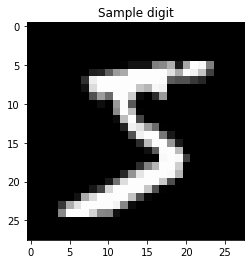

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Change datatype
x_train = x_train.astype(np.uint8)
x_test  = x_test.astype(np.uint8)

plt.imshow(x_train[0,...], cmap='gray')
plt.title("Sample digit")
plt.show()

#change [60000] to [60000,10] (one_hot)
y_train = tf.one_hot(y_train, 10).numpy()
y_test  = tf.one_hot(y_test, 10).numpy()

#reshape from a [-1,28,28] to a [-1,783] 
x_train = x_train.reshape(-1,784)
x_test  = x_test.reshape(-1, 784)

#We choose the first 1000 samples for training and reshape to [-1] and convert to a list
x_train = x_train
y_train = y_train
#initialize a list to use in js and python
mnistResults = []

Here we confirm that the arrays have been send to the js instance by logging their type and their length.

In [9]:
%%node
console.log(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype);
console.log(mnistResults);

[ 60000, 784 ] 'uint8' [ 60000, 10 ] 'float32'
[]



Here we split up our data into batches to send off to the protocol for training. This is (for the majority) the same as previous main function, but does a few things more in splitting up the data and in adding to the work function. In this example we use the `job.requires` syntax to require tensorflowjs in each of our workers. Although you could `npm.install( '@tensorflow/tfjs')` and `job.requires('@tensorflow/tfjs')`, we provide a module on DCP called `aistensorflow/tfjs` which has all of tfjs and is confirmed working for DCP.

Finally, note that we have added on the `job.on(results,()....` a push to the `mnistResults` variable declared in python above. 

In [7]:
%%node

(async function main(){
    let xtrain = x_train.typedArray;
    let ytrain = y_train.typedArray;
    let batch = 32;
    
    
    let trainingArray = [];
    for (let i of _.range(0, batch*5, batch)){
        let xs = Array.from(xtrain.slice(i*784, Math.min(xtrain.length, (i+batch)*784)));
        let ys = Array.from(ytrain.slice(i*10, Math.min(ytrain.length, (i+batch)*10)));
        trainingArray.push({xs, ys, batch});
    }
    
    let job = compute.for(trainingArray, async function(data){
        progress();
        const tf = require('aistensorflow/tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        
        const model = tf.sequential({
            layers: [
                tf.layers.dense({inputShape: [784], units:32, activation: 'relu'}),
                tf.layers.dense({units: 64, activation: 'relu'}),
                tf.layers.dense({units: 128, activation: 'relu'}),
                tf.layers.dense({units: 10, activation: 'softmax'})
            ]
        });
        progress();
        model.compile({
            optimizer: 'sgd',
            loss: 'categoricalCrossentropy',
            metrics: ['accuracy']
        })
    
        let xTrain = tf.tensor(data.xs, [data.xs.length/784, 784], dtype='float32');
        let yTrain = tf.tensor(data.ys, [data.ys.length/10, 10], dtype='int32');
        
        const history = await model.fit(xTrain, yTrain, {
            epochs: 5,
            callbacks: {
                onEpochEnd: async (epochs, logs)=>{
                    progress();
                }
            }
        });
        
        xTrain.dispose();
        yTrain.dispose();
        progress(1.0);
        return history.history.acc;
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('result', (value)=>{
        let result = value.result;
        mnistResults.push(result[result.length-1]);   
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    job.requires('aistensorflow/tfjs');
    job.public.name = 'dcp-vae-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
    console.log("Done executing job");
    console.log("Number of results: ", mnistResults.length);
})();

KeyboardInterrupt: 

## Quick Visualization 
Now that we have all these results and they are available in python, we can do some very quick data visualization in python! Here we use matplotlibs pyplot to plot the accuracies of each worker. 

In [ ]:
plt.plot(mnistResults)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

# Tensorflow to DCP

In this section we will train a model in python, convert it to js and ship it off to DCP as a module that we can require. First we begin by requiring the python tensorflowjs package which allows for python to js conversion of models.

In [ ]:
try:
    import tensorflowjs as tfjs
except:
    !pip install tensorflowjs tf-estimator-nightly
    import tensorflowjs as tfjs

Now we simply use the mnist dataset to train a simple network on mnist in python and evaluate it's performance.

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)
del x_train, x_test, y_train, y_test

Now using tensorflowjs in python and a tensorflowjs utility we have built, we can save the model to a directory and publish this model to DCP. Note that the `-p` package version number must be incremented everytime if the package name `dcp_mnist_ex/mnist.js` is not changed. 

In [ ]:
!mkdir './tfjs_model'
tfjs.converters.save_keras_model(model, './tfjs_model')
!ls './tfjs_model'
!node ~/DCP/dcp-utils/tfjs_utils/bin/serializeModel.js -m ./tfjs_model/model.json -o dcp_mnist_ex/mnist.js -p 1.0.11 -d

Now to use this model is pretty trivial. We use the same `x_train`and `y_train` variables in node that we had from before and batch them for inference using our model. We require `aistensorflow/tfjs` and `dcp_mnist_ex/mnist.js` as well as `dcp-polyfills/polyfills.js`. This allows us to `await require('mnist').getModel()` to get the mnist model we built. In order to evaluate we have to compile the model with a loss and an accuracy. Finally we evaluate the model and return our accuracy. We have reset mnistResults and so we can use it to fill it in with our accuracy.

In [ ]:
%%node
mnistResults = [];
async function main(){
    let xtrain = x_train.typedArray;
    let ytrain = y_train.typedArray;
    let batch = 32;
    
    
    let trainingArray = [];
    
    for (let i of _.range(0, 5*batch, batch)){
        let xs = Array.from(xtrain.slice(i*784, Math.min(xtrain.length, (i+batch)*784)));
        let ys = Array.from(ytrain.slice(i*10, Math.min(ytrain.length, (i+batch)*10)));
        trainingArray.push({xs, ys, batch});
    }
    
    let job = compute.for(trainingArray, async function(data){
        progress();
        require('polyfills');
        const tf = require('aistensorflow/tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        
        const model = await require('mnist').getModel();
        
        let xTrain = tf.tensor(data.xs, [data.xs.length/784, 28, 28], dtype='float32');
        let yTrain = tf.tensor(data.ys, [data.ys.length/10, 10], dtype='int32');
        
        
        model.compile({
            optimizer: 'sgd',
            loss: 'categoricalCrossentropy',
            metrics: ['accuracy']
        })
        
        const result = model.evaluate(xTrain, yTrain, {
            batchSize: 32,
        })[1];
        progress(1.0);
        return result.dataSync()[0];
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('result', (value)=>{
        mnistResults.push(value.result);
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    
    job.requires('dcp-polyfills/polyfills');
    job.requires('aistensorflow/tfjs');
    job.requires('dcp_mnist_ex/mnist');
    
    
    job.public.name = 'dcp-vae-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
    console.log("Done executing job");
};

await main();

In [ ]:
print("Accuracy for entire set: ", sum(mnistResults)/len(mnistResults))

# Variational Auto Encoder



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
try:
    import pixiedust_node
except:
    !pip install pixiedust pixiedust_node
    import pixiedust_node

ID_KEY_LOC  = '/home/mgasmallah/DCP/keys/office/id.keystore'#'/home/mgasmallah/DCP/keys/id.keystore'
ACC_KEY_LOC = '/home/mgasmallah/DCP/keys/office/default.keystore'#'/home/mgasmallah/DCP/keys/AISTEST.keystore'
SCHEDULER    = 'http://scheduler.hamada.office.kingsds.network/'#'https://demo-scheduler.distributed.computer'

node.clear();
!job-utility cancelAllJobs -I $ID_KEY_LOC --default-bank-account-file $ACC_KEY_LOC --scheduler $SCHEDULER
npm.install( 'dcp-client')

In [ ]:
%%node

process.argv.push('-I', ID_KEY_LOC, '--default-bank-account-file',ACC_KEY_LOC, '--scheduler', SCHEDULER);
require('dcp-client').initSync(process.argv)
const tf = require('@tensorflow/tfjs');
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');
var accountKeystore;
var identityKeystore;

(async function main(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    wallet.addId(identityKeystore);
    accountKeystore = await dcpCli.getAccountKeystore();
})()

In [ ]:

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = np.expand_dims(train_images,axis=-1) / 255.

train_images = train_images[:1000].reshape(-1).tolist()
latentDims = 10
numIterations = 2
numEpochs = 10


In [ ]:
%%node

mnistResults = [];

function getWeights(model){
    return tf.tidy(()=>{
        let w = model.getWeights();
        let retWeights = [];
        for (let i = 0; i < w.length; i++){
            retWeights.push({data: w[i].arraySync(), shape: w[i].shape });
        }
        return retWeights;
    });
}

function setWeights(model, weightsObj){
    return tf.tidy(()=>{
        let w = [];
        for (let i = 0; i < weightsObj.length; i++){
            w.push(tf.tensor(weightsObj[i].data, weightsObj[i].shape));
        }
        model.setWeights(w);
        return model;
    });
}

function averageWeights(ws){
    return tf.tidy(()=>{
        let outWeights = [];
        for (let i = 0; i < ws[0].length; i++){
            let w = [];
            for (let j = 0; j < ws.length; j++){
                w.push(ws[j][i].data);
            }
            let shape = ws[0][i].shape;
            shape = [w.length, ...shape];
            w = tf.tensor(w, shape).mean(axis=0);
            outWeights.push({data: w.arraySync(), shape: w.shape });
        }
        return outWeights;
    });
}


async function main(){
    
    let xtrain = Float32Array.from(train_images);
    let batch = 32;

    let trainingArray = [];
    let allEncoderWeights = [];
    let allDecoderWeights = [];
    
    for (let i=0;i< Math.floor(xtrain.length/784);i+=batch){
        let xs = Array.from(xtrain.slice(i*784, Math.min(xtrain.length, (i+batch)*784)));
        trainingArray.push({xs, latentDims, numIterations, batch});
    }
    
    
    let encoder = tf.sequential({
        layers: [
            tf.layers.conv2d({filters: 32, kernelSize: 3, strides: 2, activation: 'relu', inputShape: [28, 28, 1]}),
            tf.layers.conv2d({filters: 64, kernelSize: 3, strides: 2, activation: 'relu'}),
            tf.layers.flatten(),
            tf.layers.dense({units: latentDims + latentDims })
        ]
    });
    
    let decoder = tf.sequential({
        layers: [
            tf.layers.dense({ units: 7*7*32, activation: 'relu', inputShape: [latentDims]}),
            tf.layers.reshape({ targetShape: [7,7,32]}),
            tf.layers.conv2dTranspose({filters: 64, kernelSize: 3, strides: 2, padding: 'same',
                                      activation: 'relu'}),
            tf.layers.conv2dTranspose({filters: 32, kernelSize: 3, strides: 2, padding: 'same',
                                      activation: 'relu'}),
            tf.layers.conv2dTranspose({filters: 1, kernelSize: 3, strides: 1, padding: 'same'}),
        ]
    });
    
    
    
    
    for (let e = 0; e < numEpochs; e++){
    
        let encoderWeights = getWeights(encoder);
        let decoderWeights = getWeights(decoder);
        
        let job = compute.for(trainingArray, async function(data, eWeights, dWeights){
            progress();
            require('polyfills');
            const tf = require('aistensorflow/tfjs');
            tf.setBackend('cpu');
            await tf.ready();
            
            function getWeights(model){
                return tf.tidy(()=>{
                    let w = model.getWeights();
                    let retWeights = [];
                    for (let i = 0; i < w.length; i++){
                        retWeights.push({data: w[i].arraySync(), shape: w[i].shape });
                    }
                    return retWeights;
                });
            };
            
            function setWeights(model, weightsObj){
                return tf.tidy(()=>{
                    let w = [];
                    for (let i = 0; i < weightsObj.length; i++){
                        w.push(tf.tensor(weightsObj[i].data, weightsObj[i].shape));
                    }
                    model.setWeights(w);
                    return model;
                });
            }
            
            progress();
            
            let encoder = tf.sequential({
                layers: [
                    tf.layers.conv2d({filters: 32, kernelSize: 3, strides: 2, activation: 'relu', inputShape: [28, 28, 1]}),
                    tf.layers.conv2d({filters: 64, kernelSize: 3, strides: 2, activation: 'relu'}),
                    tf.layers.flatten(),
                    tf.layers.dense({units: data.latentDims + data.latentDims })
                ]
            });
            progress();
            let decoder = tf.sequential({
                layers: [
                    tf.layers.dense({ units: 7*7*32, activation: 'relu', inputShape: [data.latentDims]}),
                    tf.layers.reshape({ targetShape: [7,7,32]}),
                    tf.layers.conv2dTranspose({filters: 64, kernelSize: 3, strides: 2, padding: 'same',
                                              activation: 'relu'}),
                    tf.layers.conv2dTranspose({filters: 32, kernelSize: 3, strides: 2, padding: 'same',
                                              activation: 'relu'}),
                    tf.layers.conv2dTranspose({filters: 1, kernelSize: 3, strides: 1, padding: 'same'}),
                ]
            });
            progress();
            
            
            encoder = setWeights(encoder, eWeights);
            decoder = setWeights(decoder, dWeights);
            
            
            const encode = (x)=>{
                progress();
                const [ mean, logvar ] = tf.split(encoder.predict(x), 2, 1);
                progress();
                return  [ mean, logvar ];            
            };
            const decode = (z, applySigmoid)=>{
                progress();
                let logits = decoder.predict(z);
                progress();
                if (applySigmoid){
                    progress();
                    let probs = tf.sigmoid(logits);
                    return probs;
                }
                return logits;
            }


            progress();
            const sample = (eps)=>{
                progress();
                if (typeof eps === 'undefined'){
                    eps = tf.randomNormal([32, data.latentDims]);
                }
                return decode(eps, applySigmoid=true);
            };

            const reparameterize = (mean, logvar)=>{
                progress();
                let eps = tf.randomNormal([mean.shape[0], data.latentDims]);
                progress();
                return eps.mul(tf.exp(logvar.mul(.5))).add(mean);
            };

            const logNormalPdf = (sample, mean, logvar, raxis=1)=>{
                progress();
                let log2pi = tf.log(Math.PI * 2.)
                let diff = (sample.sub(mean)).pow(2);
                progress();
                diff = diff.mul(-.5);
                diff = diff.mul(tf.exp(logvar.mul(-1)));
                progress();
                diff = diff.add(logvar);
                diff = diff.add(log2pi);
                progress();
                return tf.sum(diff, raxis);
            }; 

            const computeLoss = (x)=>{
                return tf.tidy(()=>{
                    progress();
                    const [mean, logvar] = encode(x);
                    progress();
                    const z = reparameterize( mean, logvar);
                    progress();
                    const xLogit = decode(z);
                    progress();
                    const crossEntropy = tf.losses.sigmoidCrossEntropy(x, xLogit, undefined, undefined, tf.Reduction.NONE);
                    progress();
                    const logpxZ = tf.sum(crossEntropy, axis=[1,2,3]).mul(-1);
                    progress();
                    const logpz = logNormalPdf(z, tf.tensor(0.),tf.tensor(0.));
                    progress();
                    const logqzX = logNormalPdf(z, mean, logvar);
                    progress();
                    let loss = logpxZ.add(logpz);
                    progress();
                    loss = loss.sub(logqzX);
                    progress();
                    loss = tf.mean(loss).mul(-1);
                    progress();
                    return loss;
                });
            };

            const optimizer = tf.train.adam(0.0001)

            let l = 0;

            let xs = tf.tensor(data.xs, [data.xs.length/784, 28,28,1], dtype='float32');
            for (let i=0; i< data.numIterations; i++){
                l = 0;
                l += optimizer.minimize(()=>computeLoss(xs), true);
                progress();
            }
            progress();
            eWeights = getWeights(encoder);
            progress();
            dWeights = getWeights(decoder);
            console.log("Done slice");
            progress(1.0);
            
            return { loss: l.arraySync(), eWeights, dWeights };
        }, [encoderWeights, decoderWeights]);

        job.on('accepted', ()=>{
            console.log('Job accepted...');
        });
        job.on('status', (status)=>{
            console.log('Got a status update: ', status);
        });
        job.on('result', (value)=>{
            allEncoderWeights.push(value.result.eWeights);
            allDecoderWeights.push(value.result.dWeights);
        });
        job.on('console', (output)=>{
            console.log(output.message);
        });
        job.on('error', (err)=>{
            console.log(err);
        });

        //job.requirements.environment.offscreenCanvas = true;

        job.requires('dcp-polyfills/polyfills');
        job.requires('aistensorflow/tfjs');


        job.public.name = 'dcp-vae-testing';
        console.log("Launching job");
        let results = await job.exec(compute.marketValue, accountKeystore);
        
        let avgEncWeights = averageWeights(allEncoderWeights);
        let avgDecWeights = averageWeights(allDecoderWeights);
        
        encoder = setWeights(encoder, avgEncWeights);
        decoder = setWeights(decoder, avgDecWeights);
    }
    console.log("Done executing job");
};

main();

In [ ]:
plt.imshow(np.array(mnistResults[3]['img'])[0,:,:,0], cmap='gray')

In [ ]:
node.clear()